In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import string
import typing as tp

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semeval-2016-task-5-absa/train_data.csv
/kaggle/input/semeval-2016-task-5-absa/config.pkl
/kaggle/input/semeval-2016-task-5-absa/eval_data.csv
/kaggle/input/semeval-2016-task-5-absa/absa_lstm_best.pt
/kaggle/input/semeval-2016-task-5-absa/SemEval-2016/SemEval-2016/laptops_trial_english_sl.xml
/kaggle/input/semeval-2016-task-5-absa/SemEval-2016/SemEval-2016/restaurants_trial_english_sl.xml
/kaggle/input/semeval-2016-task-5-absa/SemEval-2016/SemEval-2016/ABSA16_Restaurants_Train_English_SB2.xml
/kaggle/input/semeval-2016-task-5-absa/SemEval-2016/SemEval-2016/ABSA16_Laptops_Train_SB1_v2.xml
/kaggle/input/semeval-2016-task-5-absa/SemEval-2016/SemEval-2016/restaurants_trial_english_tl.xml
/kaggle/input/semeval-2016-task-5-absa/SemEval-2016/SemEval-2016/laptops_trial_english_tl.xml
/kaggle/input/semeval-2016-task-5-absa/SemEval-2016/SemEval-2016/ABSA16_Restaurants_Train_SB1_v2.xml
/kaggle/input/semeval-2016-task-5-absa/SemEval-2016/SemEval-2016/ABSA16_Laptops_Train_English_SB2.

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Analysis of Instagram data

In this module let's look through the block of data we scraped from instagrm. We may notice how there're different objects such as html <br> or <a> that we obviously need to get rid of. Also I'd like to discover the percentage of texsts that are english. I am planning to remove all unenglish words as well as stopwords, but leaving emoticons and emojis possibly used as part of text data.

In [3]:
!pip install emot
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO  

def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, " " + "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, "".join(EMOTICONS_EMO[emot].replace(" ","_").replace(":","").split(",")))
    return text

emoticon_pattern = re.compile(u'(' + u'|'.join(re.escape(k) for k in UNICODE_EMOJI) + u')')
def remove_emoticons(text):
    return emoticon_pattern.sub(r'', text)

def count_number_emojis_emoticons(text):
    number_emojis = 0
    for emot in UNICODE_EMOJI:
        number_emojis += len(re.findall(re.escape(emot), text))
    for emot in EMOTICONS_EMO:
        number_emojis += len(re.findall(re.escape(emot), text))
    return number_emojis

print(f'🧑‍💻👏 -> {convert_emojis("🧑‍💻👏")}')
print(f':) :-( :/ -> {convert_emoticons(":) :-( :/")}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.6 MB/s eta 0:00:00
🧑‍💻👏 ->  person‍ laptop clapping_hands
:) :-( :/ -> Happy_face_or_smiley Frown_sad_andry_or_pouting Skeptical_annoyed_undecided_uneasy_or_hesitant


In [4]:
words = set(nltk.corpus.words.words())

def filter_english_comment(comment: str) -> tp.List[str]:
    """Process comment function.
    Input:
        comment: a string containing a comment or tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    """
    # remove stock market tickers like $GE
    comment = re.sub(r'\$\w*', '', comment)
    # remove old style retweet text "RT"
    comment = re.sub(r'^RT[\s]+', '', comment)
    # remove hyperlinks
    comment = re.sub(r'https?:\/\/.*[\r\n]*', '', comment)
    # remove hashtags
    # only removing the hash # sign from the word
    comment = re.sub(r'#', '', comment)
    # remove emoticons since some of them have english letters :D
    comment = remove_emoticons(comment)
    
    # tokenize tweets
    comment_cleared = " ".join(w for w in nltk.wordpunct_tokenize(comment) \
             if w.lower() in words)
    return comment_cleared

def filter_english_comments(comments):
    comments_cleared = []
    for comment in comments:
        comment_cleared = filter_english_comment(comment)
        if len(comment_cleared) > 0:
            comments_cleared.append(comment_cleared)
    return comments_cleared

In [ ]:
!pip install langdetect
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

def get_language(text):
    try:                                                          
        lang=detect(text)                                      
    except:                                                       
        lang='no'
    return lang

In [24]:
# Load the Instagram data
path_to_csv = "/kaggle/input/instagram-posts/content.csv"

instagram_data = pd.read_csv(path_to_csv)
instagram_data = instagram_data[instagram_data["comments"].notna()]
instagram_data.head()

,post_id,tags,company,image_url,image_file,caption,comments,number_comments
0,C6Gy2u6Nffj,NaN,apple,https://www.instagram.com/p/C6Gy2u6Nffj/?img_i...,NaN,📲 4 𝗺𝗼𝘀𝘁 𝗰𝗼𝗺𝗺𝗼𝗻 𝗺𝗶𝘀𝘁𝗮𝗸𝗲𝘀 to avoid when 𝗯𝘂𝗶𝗹𝗱𝗶𝗻...,Mistake 5: buying 8gb MacBook\nNice laptop and...,4
1,C6Lm5lyNoMT,NaN,apple,https://www.instagram.com/p/C6Lm5lyNoMT/?img_i...,NaN,Rate this setup 👇🤓🚀\n.\n.\nPhoto by: @mobilede...,@auredivisa\nSetup 🔥 But Hope the bugs don't f...,4
2,C6EOZlKtDd6,NaN,apple,https://www.instagram.com/p/C6EOZlKtDd6/?img_i...,NaN,Rate this setup 👇🤓🚀\n.\n.\nPhoto by: @justinbi...,Keyboard looks like inspired from cybertruck😀\...,6
3,C58Z0YHtJwK,NaN,apple,https://www.instagram.com/p/C58Z0YHtJwK/?img_i...,NaN,📱 𝗦𝘁𝗮𝗿𝘁𝗶𝗻𝗴 𝗽𝗿𝗼𝗷𝗲𝗰𝘁𝘀 & 𝗮𝗽𝗽𝘀 𝗳𝗿𝗼𝗺 𝘀𝗰𝗿𝗮𝘁𝗰𝗵: the G...,Helpful post 👏\nbrighthacker01 got me full acc...,5
4,C5YUXZvNNI9,NaN,apple,https://www.instagram.com/p/C5YUXZvNNI9/?img_i...,NaN,🧑‍💻 In a remote-first Software Engineering wor...,Being able to work from anywhere is the best! ...,6


### Count Distribution of Instagram Comments

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


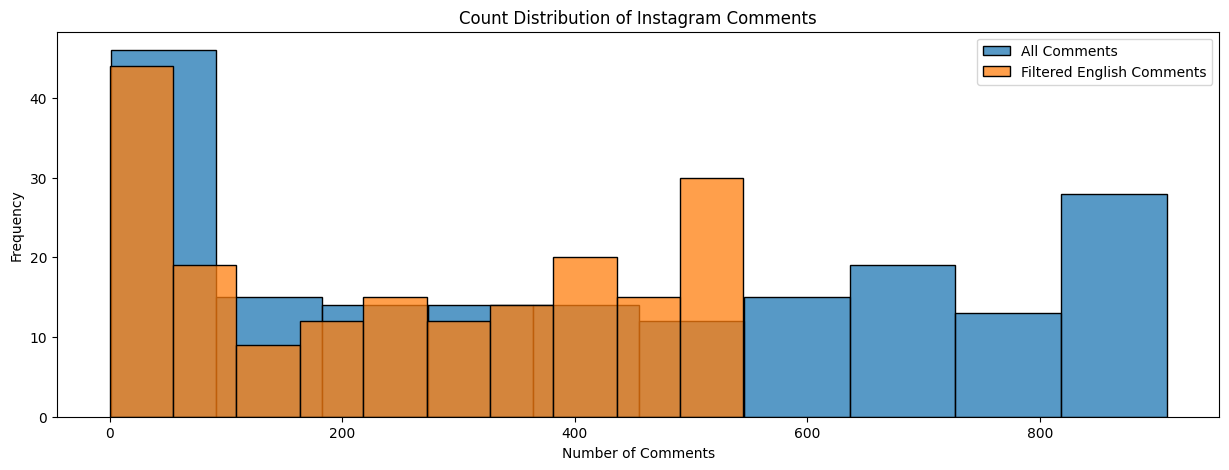

In [27]:
# Get the count of all comments and sort it
all_comments_counts = instagram_data["comments"].dropna().apply(lambda x: len(x.split("\n"))).to_numpy()
all_comments_counts.sort()

# Get the count of filtered ONLY English comments and sort it
english_comments_counts = instagram_data["comments"].dropna().apply(lambda x: len(filter_english_comments(x.split("\n")))).to_numpy()
english_comments_counts.sort()

plt.figure(figsize=(15, 5))
sns.histplot(all_comments_counts, bins=10, label="All Comments")
sns.histplot(english_comments_counts, bins=10, label="Filtered English Comments")

plt.title("Count Distribution of Instagram Comments")
plt.xlabel("Number of Comments")
plt.ylabel("Frequency")
plt.legend()
plt.savefig('/kaggle/working/count_distribution.png')

### Count distribution of Instagram captions

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


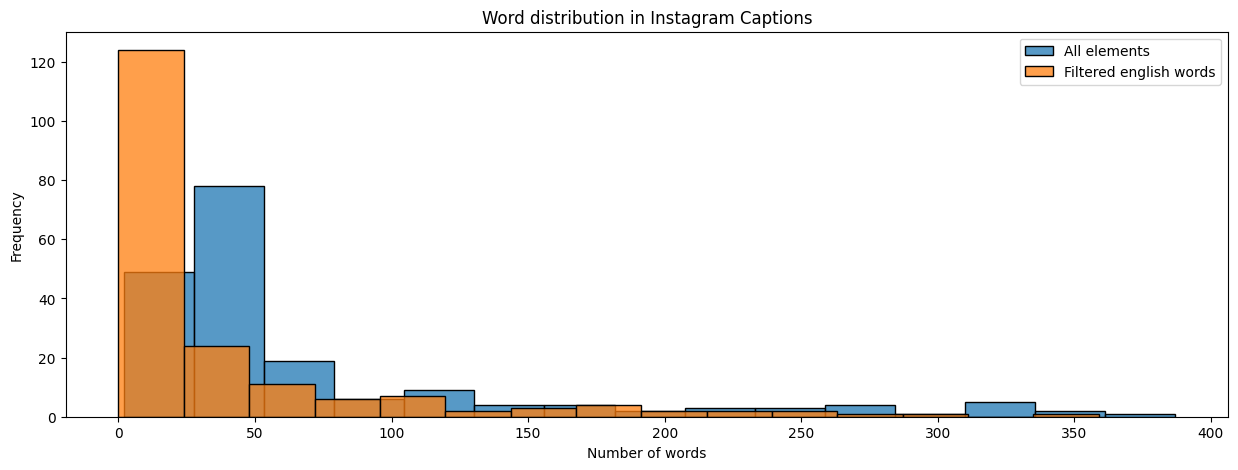

In [29]:
# Get the count of all comments and sort it
all_words_counts = instagram_data["caption"].dropna().apply(lambda x: len(x.split())).to_numpy()
all_words_counts.sort()

# Get the count of filtered ONLY English comments and sort it
english_words_counts = instagram_data["caption"].dropna().apply(lambda x: len(filter_english_comment(x).split())).to_numpy()
english_words_counts.sort()

plt.figure(figsize=(15, 5))
sns.histplot(all_words_counts, bins=15, label="All elements")
sns.histplot(english_words_counts, bins=15, label="Filtered english words")

plt.title("Word distribution in Instagram Captions")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.legend()
plt.savefig('/kaggle/working/count_caption_len_distribution.png')

### Count Distribution of english words and emojis per Instagram Comment

In [28]:
words = set(nltk.corpus.words.words())
for comments in instagram_data["comments"][:10]:
    comment = np.random.choice(comments.split("\n"))
    comment_cleared = " ".join(w for w in nltk.wordpunct_tokenize(comment) \
             if w.lower() in words or not w.isalpha())
    print(comment_cleared)

Good 🔥
@
Keyboard like inspired from 😀
Helpful post 👏
Being able to work from anywhere is the best ! 🙌
Wow . How did you know ?
Great post 👏👏👏👏🙌🙌🙌
… al 2
y , para al final es poco de y vale lo te un o te y , con y peso
❤️


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


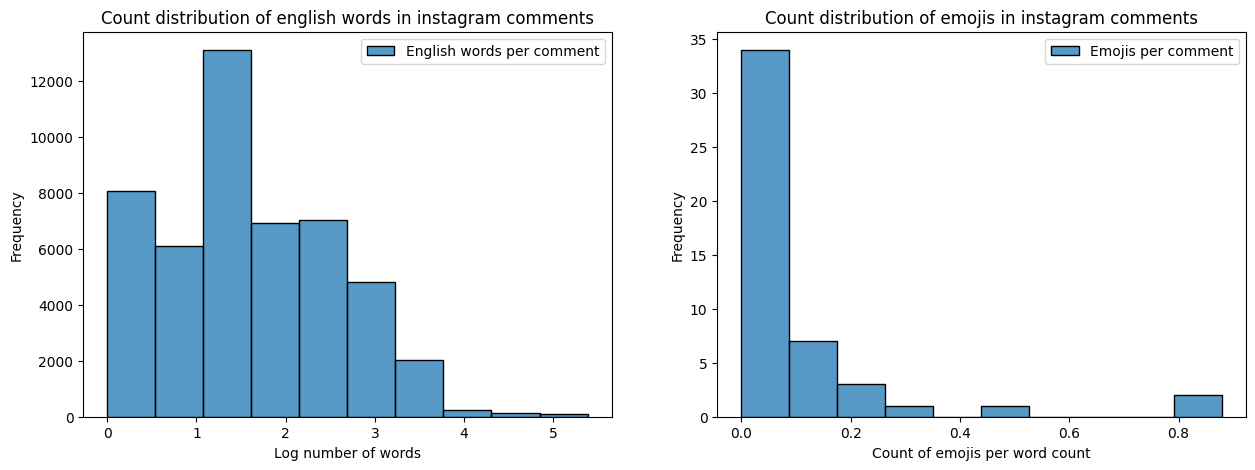

In [29]:
num_words_per_comment = [np.log(len(comment.split())) for comment in instagram_data["comments"].dropna() for comment in filter_english_comments(comment.split("\n"))]
num_words_per_comment.sort()

emojis_number_per_bucket = instagram_data["comments"][:50].apply(lambda x: count_number_emojis_emoticons(x))
num_words_per_bucket = instagram_data["comments"][:50].apply(
    lambda x: sum(map(lambda y: len(y), filter_english_comments(x.split("\n"))))
)
emojis_number_per_words = emojis_number_per_bucket/num_words_per_bucket
emojis_number_per_words = emojis_number_per_words.dropna().to_numpy()
emojis_number_per_words.sort()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(num_words_per_comment, bins=10, ax=ax1, label="English words per comment")
sns.histplot(emojis_number_per_words, bins=10, ax=ax2, label="Emojis per comment")

ax1.set_title("Count distribution of english words in instagram comments")
ax1.set_xlabel("Log number of words")
ax1.set_ylabel("Frequency")
ax1.legend()

ax2.set_title("Count distribution of emojis in instagram comments")
ax2.set_xlabel("Count of emojis per word count")
ax2.set_ylabel("Frequency")
ax2.legend()

plt.savefig('/kaggle/working/count_word_distribution.png')

As we can see the destribution of word count strongly revolves around mere 4-5 words. Obviously that's barely enough to hold any information except possibly sentimental one. Meanwhile the comments are showing seemingly essential percentage. 

Now let's see what are most popular emojis. Obviously leaving too many in would result in longer and unnecessary operations, therefore we'll only leave the essential emojis

In [30]:
import heapq

def update_emoji_ocurance(text, EMOJI_TO_COUNT):
    for emot in EMOJI_TO_COUNT:
        EMOJI_TO_COUNT[emot] += len(re.findall(re.escape(emot), text))
def get_top_k_emojis_by_frequency(texts, k=20):
    EMOJI_TO_COUNT = dict.fromkeys([*UNICODE_EMOJI.keys(), *EMOTICONS_EMO.keys()], 0)
    for text in texts:
        update_emoji_ocurance(text, EMOJI_TO_COUNT)
    k_keys_sorted_by_values = heapq.nlargest(k, EMOJI_TO_COUNT, key=EMOJI_TO_COUNT.get)
    return k_keys_sorted_by_values

In [ ]:
instagram_top_emojis = get_top_k_emojis_by_frequency(instagram_data["comments"])
instagram_top_emojis

### Language distribution

As we can see there are lot's of not english comments & posts in the data, so we have three options - either ignore them, or translate them to english with google, or build model supporting multiple languages. So to decide on best approach, let's first see the distribution of the languages in instagram data.

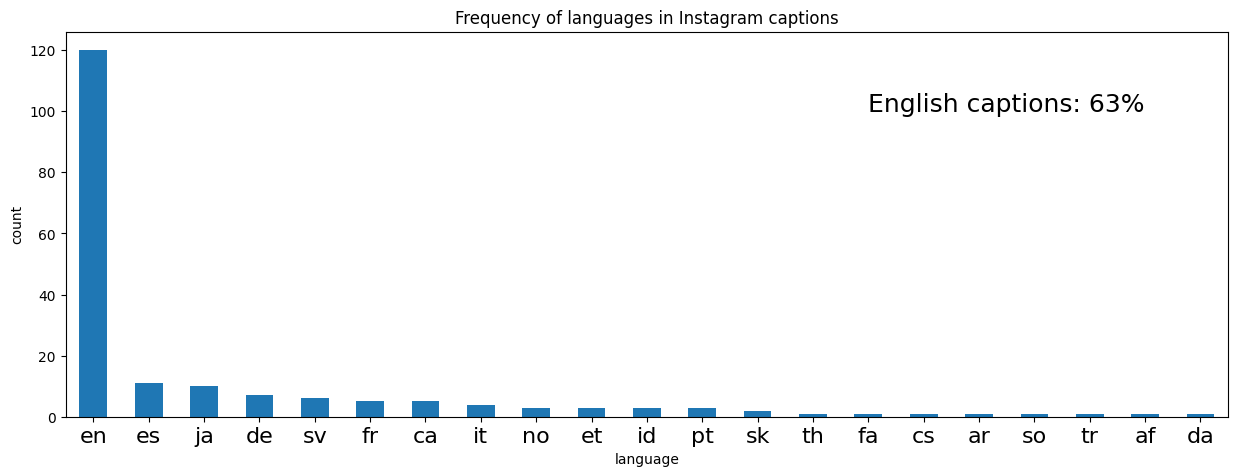

In [18]:
language_counts = instagram_data.caption.apply(get_language).value_counts()
english_percent = int(language_counts["en"] / language_counts.sum() * 100)

plt.figure(figsize=(15,5))
ax = language_counts.plot.bar(rot=0)
plt.setp(ax.get_xticklabels(), fontsize=16)
plt.text(14, 100, f"English captions: {english_percent}%", fontsize = 18)
plt.xlabel("language")
plt.ylabel("count")
plt.title('Frequency of languages in Instagram captions')
plt.savefig('/kaggle/working/count_caption_language_distribution.png')

In [37]:
language_counts[:5].sum() / language_counts.sum()

0.8105263157894737

The plot shows that english captions are in majority despite still in levels, which are not enough in my view. Taking the top 5 popular languages should be enough to cover 80% of posts:
- English
- Spanish, Castilian
- Japanese
- German
- Swedish

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


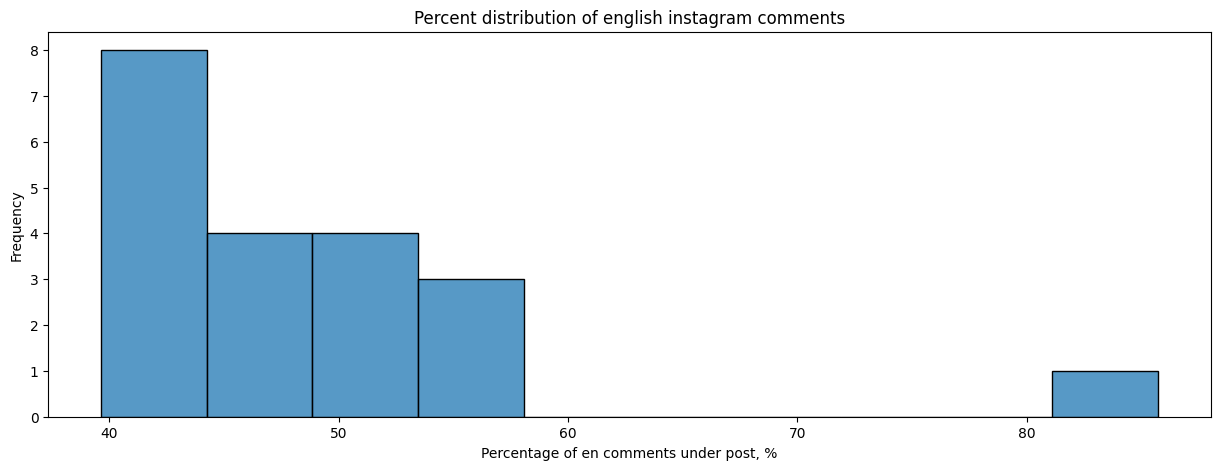

In [25]:
def count_english_comment_percent(comments):
    return sum([get_language(comment) == "en" for comment in comments]) / len(comments) * 100

indices = np.random.choice(np.arange(instagram_data["comments"].shape[0]), 20, replace=False)
english_comments_precent = instagram_data["comments"].iloc[indices].apply(
    lambda x: count_english_comment_percent(x.split("\n"))
)

plt.figure(figsize=(15,5))
sns.histplot(english_comments_precent, bins=10)
plt.title("Percent distribution of english instagram comments")
plt.xlabel("Percentage of en comments under post, %")
plt.ylabel("Frequency")
plt.savefig('/kaggle/working/precentage_comment_language_distribution.png')

It's noticable that most posts have rather mixed comments, even though the major language is english. So possibly we could either translate them or cover most popular five languages. My personal goal is to analyze around 80% of scraped data.

### Analyzing twitter comments

Since we need to train some model for sentiment analysis, we'll need supervised data. The most onbious solution for this - take some dataset with relatively simular data. The one that fits perfectly - twitter comments, a dataset from nltk library that consists of 5000 positive and 5000 negative tweets. We'll shortly discover whether the data we're looking for is simular to ours and then proceed to building the model

In [11]:
from nltk.corpus import twitter_samples         
import random

nltk.download('twitter_samples')
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [32]:
all_positive_tweets[2]

'@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!'

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


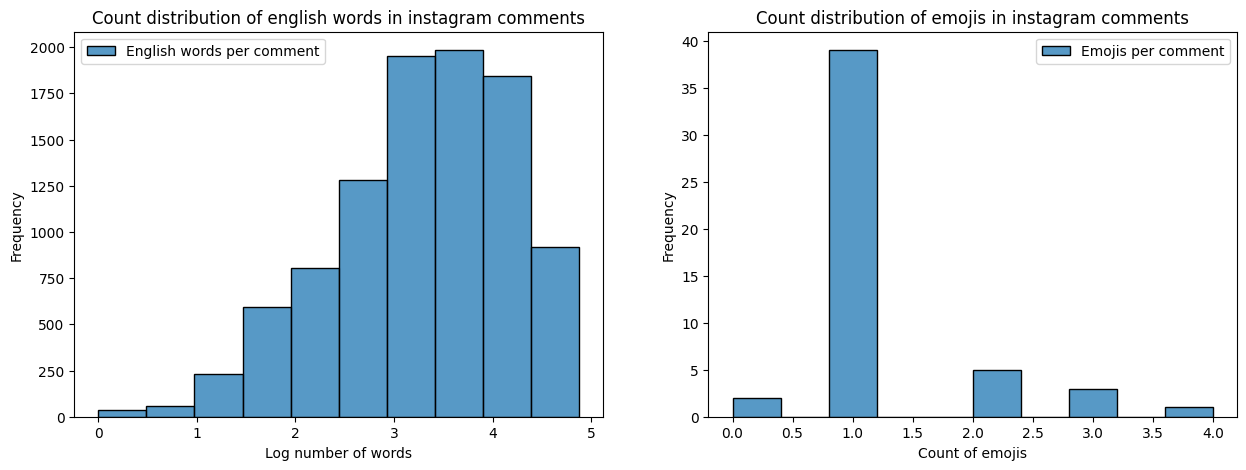

In [33]:
all_tweets = [*all_positive_tweets, *all_negative_tweets]
num_words_per_comment = np.array([np.log(len(comment)) for comment in filter_english_comments(all_tweets)])
num_words_per_comment.sort()

num_emojis_per_comment = np.array([count_number_emojis_emoticons(tweet) for tweet in np.random.choice(all_tweets, 50)])
num_emojis_per_comment.sort()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(num_words_per_comment, bins=10, ax=ax1, label="English words per comment")
sns.histplot(num_emojis_per_comment, bins=10, ax=ax2, label="Emojis per comment")

ax1.set_title("Count distribution of english words in instagram comments")
ax1.set_xlabel("Log number of words")
ax1.set_ylabel("Frequency")
ax1.legend()

ax2.set_title("Count distribution of emojis in instagram comments")
ax2.set_xlabel("Count of emojis")
ax2.set_ylabel("Frequency")
ax2.legend()

plt.savefig('/kaggle/working/count_word_tweet_distribution.png')

In [ ]:
twitter_top_emojis = get_top_k_emojis_by_frequency(np.random.choice(all_tweets, 100), k=40)
twitter_top_emojis

In [12]:
!pip install contractions
from bs4 import BeautifulSoup
import contractions

def html_remover(data):
    beauti = BeautifulSoup(data,'html.parser')
    return beauti.get_text()

def contraction_replace(data):
    return contractions.fix(data)

def remove_punc(data):
    trans = str.maketrans('','', string.punctuation)
    return data.translate(trans)

def white_space(data):
    return ' '.join(data.split())

def preprocess_tweet(tweet):
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) # remove links
    tweet = re.sub(r'#', '', tweet) # remove hashtags
    tweet = html_remover(tweet) # remove <bs> and such
    tweet = re.sub('\(.*?\)','',tweet) # remove round brackets
    tweet = remove_punc(tweet) # remove punkt
    tweet = contraction_replace(tweet) # replace contractions
    tweet = white_space(tweet) # remove unnecessary \n and whitespaces
    return tweet

print(all_positive_tweets[0])
print(preprocess_tweet(all_positive_tweets[0]))

#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
FollowFriday FranceInte PKuchly57 MilipolParis for being top engaged members in my community this week


In [ ]:
# Get the count of all comments and sort it
all_comments_counts = instagram_data["comments"].dropna().apply(lambda x: len(x.split("\n"))).to_numpy()
all_comments_counts.sort()

# Get the count of filtered ONLY English comments and sort it
english_comments_counts = instagram_data["comments"].dropna().apply(lambda x: len(filter_english_comments(x.split("\n")))).to_numpy()
english_comments_counts.sort()

plt.figure(figsize=(15, 5))
sns.histplot(all_comments_counts, bins=10, label="All Comments")
sns.histplot(english_comments_counts, bins=10, label="Filtered English Comments")

plt.title("Count Distribution of Instagram Comments")
plt.xlabel("Number of Comments")
plt.ylabel("Frequency")
plt.legend()
plt.savefig('/kaggle/working/count_distribution.png')

# Preprocessing block

Now we'll remmeber that we have two parts to acomplish - Aspect based sentiment analysis and basic one. Typical use cases for sentiment analysis, including proper handling of sentences with:

- typical negations (e.g., "not good")
- use of contractions as negations (e.g., "wasn't very good")
- conventional use of punctuation to signal increased sentiment intensity (e.g., "Good!!!")
- conventional use of word-shape to signal emphasis (e.g., using ALL CAPS for words/phrases)
- using degree modifiers to alter sentiment intensity (e.g., intensity boosters such as "very" and intensity dampeners such as "kind of")
- understanding many sentiment-laden slang words (e.g., 'sux')
- understanding many sentiment-laden slang words as modifiers such as 'uber' or 'friggin' or 'kinda'
- understanding many sentiment-laden emoticons such as :) and :D
- translating utf-8 encoded emojis such as 💘 and 💋 and 😁
- understanding sentiment-laden initialisms and acronyms (for example: 'lol')

Here, we will write the functions for preprocessing the comments as well as caption. As one could notice, instagram which is our target social net lacks in comments, especially informative ones. Most comments consist of at most one sentence and have emoticons. In contrast some captions have larger texsts. Therefore I came up with idea of processing comments and captions seperately.

Since we're running low on text in comments, we're going to leave emojis and emoticons as they hold valuable information about sentiment. But since we'd rather keep the compatibility with most of pretrained language models, the better approach is to convert emoji to word format. For example: 🍕 -> "pizza". Obviously we aren't keeping all emojis, only most popular and relevant ones, also there'll still be issues with text replacement - being that it's always one-word style.

In [9]:
all_tweets = [*all_positive_tweets, *all_negative_tweets]
for tweet in np.random.choice(all_tweets, 5):
    print(f"Original: {tweet}")
    print(f"Filtered: {filter_english_comment(tweet)}")
    print("_________________________________________")

Original: @Cas_Audio noooooooooooooooooo. This cannot be a thing. :-( :-( x
Filtered: This cannot be a thing x
_________________________________________
Original: @rainymondays luv u 💖 ps. We haven't talked in a looooong time :-( why??
Filtered: u We haven t in a time why
_________________________________________
Original: Omg no Amber :((
Filtered: no Amber
_________________________________________
Original: @ChaSilveo  follow @jnlazts &amp; http://t.co/RCvcYYO0Iq follow u back :)
Filtered: follow
_________________________________________
Original: Hoya mah always good looking :(
No comment aing :(
Filtered: always good looking No comment
_________________________________________


In [13]:
def clean_text_from_special(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) # Remove Mentions
    text = re.sub(r"#", "", text) # Remove Hashtags Symbol
    text = re.sub(r"RT[\s]+", "", text) # Remove Retweets
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove The Hyper Link
    return text

def clean_text(text):
    text = clean_text_from_special(text)
    text = filter_english_comment(text)
    return text

## Sentiment analysis

### Intro to sentiment analysis

Sentiment analysis means computing in some way the overall valence of the text. Valence usually means whether a text is negative, neutral or positive.

Different libraries / algorithms assess text valence in different ways, but this would be the gist of the sentiment analysis.

The most popular algorithms are:

- Rule-based models
For example, TextBlob and Vader They use a bag-of-words approach: the text is considered to be the sum of its constituent words,
- Word-embedding-based models:
Words are represented as vectors of numbers in an n-dimensional space This mapping from individual words to a continuous vector space can be generated through various methods: neural networks, dimensionality reduction, co-occurence matrix

### Popular libraries for sentiment analysis

For this analysis of tweets I tried three of the currently most popular sentiment analysis libraries.
TextBlob and Vader use rule-based models, while Flair uses word embeddings.

All three output a continuous number between -1 and 1.
If one needs a classification into categories instead of these numerical values, the common interpretation is that <0 is negative, 0 is neutral and >0 is positive. The cutoff points for the three categories are not set in stone and can be adapted based on the results / visual inspection.

Let’s discuss the differences now:

- TextBlob is the simplest of them It does estimate though how factual versus opinionated a text is
- Vader The valence for the words in the dictionary was empirically validated by multiple human judges “especially attuned to microblog-like contexts”
Uses some heuristics to recognize word negations (“cool” versus “not cool”) and word intensifiers (“a bit sad” versus “really sad”)
Cannot recognize typos and will consider them out of vocabulary words (veri relevant for twitter, where users tend to not spell correctly)
- Flair is a pre-trained character-level LSTM (recurrent neural networks) classifier which takes into account:
the sequence of words
the sequence of letters -> recognizes typos
intensifiers ('so', 'very', ‘a bit’ etc)
Flair is trained on IMDB movie reviews dataset and retraining is resource intensive.
Very polarizing (assigns very positive or very negative scores), but not much in the middle

### TextBlob

In [15]:
from textblob import TextBlob

def sentiment_analysis(df):
    sentiment = df['text'].apply(lambda row: TextBlob(row).sentiment)
    df['subjectivity'] = sentiment.apply(lambda x: x.subjectivity)
    df['polarity'] = sentiment.apply(lambda x: (x.polarity + 1)/2)
    return df

all_tweets = pd.Series([*all_positive_tweets, *all_negative_tweets])
all_tweets = all_tweets.apply(clean_text)
df = pd.DataFrame({'text': all_tweets, "true_polarity": [*([1]*5000), *([0]*5000)]})
df = (df.pipe(sentiment_analysis))
df.head()

,text,true_polarity,subjectivity,polarity
0,for being top engaged in my community this week,1,0.500000,0.750000
1,Hey How odd Please call our Contact on and we ...,1,0.393750,0.629167
2,we had a listen last night As You Bleed is an ...,1,0.483333,0.650000
3,,1,0.000000,0.500000
4,my succeed got a blue tick mark on my profile ...,1,0.100000,0.500000


In [17]:
accuracy = ((df["polarity"] > 0.5) == df["true_polarity"]).sum() / df.shape[0]
mse = ((df["polarity"] - df["true_polarity"])**2).mean()
print(f"TextBlob\n\taccuracy: {accuracy}\n\tMSE: {mse}")

print(f'positive: {(df["polarity"] > 0.5).sum()}, neutral: {(df["polarity"] == 0.5).sum()}, negative: {(df["polarity"] < 0.5).sum()}')
print(f"Among neutral:\n\ttrue positive: {df[df['polarity'] == 0.5]['true_polarity'].sum()}, true negative: {(df['polarity'] == 0.5).sum() - df[df['polarity'] == 0.5]['true_polarity'].sum()}")

TextBlob
	accuracy: 0.6324
	MSE: 0.22474752768011103
positive: 3754, neutral: 4834, negative: 1412
Among neutral:
	true positive: 2154, true negative: 2680


### Vader

[VADER](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary for Sentiment Reasoning) was developed in 2014. VADER incorporates a "gold-standard" sentiment lexicon that is especially attuned to microblog-like contexts.

Vader is a pre-trained model. If you want to read about the model in detail, the official website recommends [2]

Vader outputs something like this:
{'neg': 0.0, 'neu': 0.436, 'pos': 0.564, 'compound': 0.3802}

Important thing about VADER is that it already preprocesses texts on it's own, including emoji handling and such.

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def vader_clear_text(text):
    return clean_text_from_special(text)
    
def sentiment_analysis_vader(df, analyzer, clean = True):
    if clean:
        target_col = 'clean_text'
        prefix = 'vader_clean_'
    else:
        target_col = 'text'
        prefix = 'vader_'

    scores_col = prefix+'scores'
    compound_col = prefix+'polarity'
    comp_score_col = prefix+'sentiment' 

    df[scores_col] = df[target_col].apply(lambda text: analyzer.polarity_scores(text))
    df[compound_col] = df[scores_col].apply(lambda d: (d['compound'] + 1)/2)
    return df
    
all_tweets = pd.Series([*all_positive_tweets, *all_negative_tweets])
all_tweets = all_tweets.apply(vader_clear_text)
df = pd.DataFrame({'clean_text': all_tweets, "true_polarity": [*([1]*5000), *([0]*5000)]})
analyzer = SentimentIntensityAnalyzer()
sentiment_analysis_vader(df, analyzer, clean=True)
df.head()

,clean_text,true_polarity,vader_clean_scores,vader_clean_polarity
0,FollowFriday _Inte _Paris for being top engag...,1,"{'neg': 0.0, 'neu': 0.595, 'pos': 0.405, 'comp...",0.87895
1,Hey James! How odd :/ Please call our Contact...,1,"{'neg': 0.149, 'neu': 0.572, 'pos': 0.279, 'co...",0.81145
2,we had a listen last night :) As You Bleed is...,1,"{'neg': 0.0, 'neu': 0.693, 'pos': 0.307, 'comp...",0.89795
3,CONGRATS :),1,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...",0.89915
4,yeaaaah yippppy!!! my accnt verified rqst has...,1,"{'neg': 0.0, 'neu': 0.718, 'pos': 0.282, 'comp...",0.89750


In [12]:
accuracy = ((df["vader_clean_polarity"] > 0.5) == df["true_polarity"]).sum() / df.shape[0]
mse = ((df["vader_clean_polarity"] - df["true_polarity"])**2).mean()
print(f"VADER\n\taccuracy: {accuracy}\n\tMSE: {mse}")

print(f'positive: {(df["vader_clean_polarity"] > 0.5).sum()}, neutral: {(df["vader_clean_polarity"] == 0.5).sum()}, negative: {(df["vader_clean_polarity"] < 0.5).sum()}')
print(f"Among neutral:\n\ttrue positive: {df[df['vader_clean_polarity'] == 0.5]['true_polarity'].sum()}, true negative: {(df['vader_clean_polarity'] == 0.5).sum() - df[df['vader_clean_polarity'] == 0.5]['true_polarity'].sum()}")

VADER
	accuracy: 0.8568
	MSE: 0.1236208914655
positive: 5662, neutral: 595, negative: 3743
Among neutral:
	true positive: 182, true negative: 413


## Aspect-Based Sentiment Analysis (ABSA)

Since I had no time or sorces to parametrize the data I scraped, I decided to search the internet for ready alternatives. In result, I found a dataset that has been mentioned in multiple articles and therefore seemed relieable. The dataset itself came from a challenge along with a paper. The challenge can be found here [SemEval Task 5](https://alt.qcri.org/semeval2016/task5/index.php?id=data-and-tools). They provide reviews for seperate domains:

- Restaurants
- - Subtask 1: English, Dutch, French, Russian, Spanish, Turkish
- - Subtask 2: English, Dutch, Russian, Spanish, Turkish
- Hotels
- - Subtask 1:  Arabic
- - Subtask 2:  Arabic
- Consumer Electronics
- - Subtask 1: English (Laptops) , Chinese (Mobile Phones), Chinese (Digital Cameras),  Dutch (Mobile Phones)
- - Subtask 2: English (Laptops)
- Telecom
- - Subtask 1: Turkish
 
Why it serves our purposes perfectly, is due to the sentiment linked to a certain single aspect that may be tied to quality or something specific as well as general. Our first goal would be to find a suitable subset of aspects that we will concentrate on, most likely up to 10 of total amount. Since there is obviously an inconsistent set of language (moreover we may only be interested in Dutch or Spanish per say), we'll start by english tracks only and see how it goes. I downloaded the corresponding xmls and uploaded them as a dataset. You can [view it on kaggle](https://www.kaggle.com/datasets/alice6fox/semeval-2015-2016-task-5-12-absa) or register on http://metashare and download files directly.

Subtasks differ in the way texts and opinions are related. In case of subtask 1 each sentence has it's seperate list of opinions while in subtask 2 the list is provided for full text. Considering that we're interested in analyzing captions, we'll be interested in full texts, therefore subtask 2. As I notcied while exploring data subtask 1 and subtask 2 texts pretty much repeat each other, so we'll ignore the first one.

### Loading data

In [6]:
!ls /kaggle/input/semeval-2016-task-5-absa/SemEval-2016
ROOT_SEM_EVAL = "/kaggle/input/semeval-2016-task-5-absa/SemEval-2016"
LAPTOP_TRAIN_1 = ROOT_SEM_EVAL+ "/ABSA16_Laptops_Train_SB1_v2.xml"
LAPTOP_TRAIN_2 = ROOT_SEM_EVAL+ "/ABSA16_Laptops_Train_English_SB2.xml"
LAPTOP_TRIAL_1 = ROOT_SEM_EVAL+ "/laptops_trial_english_sl.xml"
LAPTOP_TRIAL_2 = ROOT_SEM_EVAL+ "/laptops_trial_english_tl.xml"

RESTAURANT_TRAIN_1 = ROOT_SEM_EVAL+ "/ABSA16_Restaurants_Train_SB1_v2.xml"
RESTAURANT_TRAIN_2 = ROOT_SEM_EVAL+ "/ABSA16_Restaurants_Train_English_SB2.xml"
RESTAURANT_TRIAL_1 = ROOT_SEM_EVAL+ "/restaurants_trial_english_sl.xml"
RESTAURANT_TRIAL_2 = ROOT_SEM_EVAL+ "/restaurants_trial_english_tl.xml"

ABSA16_Laptops_Train_English_SB2.xml	  laptops_trial_english_sl.xml
ABSA16_Laptops_Train_SB1_v2.xml		  laptops_trial_english_tl.xml
ABSA16_Restaurants_Train_English_SB2.xml  restaurants_trial_english_sl.xml
ABSA16_Restaurants_Train_SB1_v2.xml	  restaurants_trial_english_tl.xml


In [7]:
from xml.etree import ElementTree as ET
import io

def parse_semeval_2016_xml(xml_file, by_sentence=False):
    root = None

    with open(xml_file) as f:
        xml_data = io.StringIO(f.read())
        tree = ET.parse(xml_data)
        root = tree.getroot()
        
    
    reviews_df = pd.DataFrame(columns=["review_id", "text"])
    opinions_df = pd.DataFrame(columns=["review_id", "category", "subcategory", "polarity"])

    for review in root.findall("Review"):
        review_id = review.get("rid")

        sentences = []
        for sentence in review.find("sentences").findall("sentence"):
            sentences.append(sentence.find("text").text)
            if by_sentence:
                if sentence.find("Opinions") is None:
                    continue
                for opinion in sentence.find("Opinions").findall("Opinion"):
                    category, subcategory = opinion.get("category").split("#")
                    polarity = opinion.get("polarity")
                    opinions_df.loc[len(opinions_df)] = [review_id, category, subcategory, polarity]

        reviews_df.loc[len(reviews_df)] = [review_id, sentences]
        if not by_sentence:
            for opinion in review.find("Opinions").findall("Opinion"):
                category, subcategory = opinion.get("category").split("#")
                polarity = opinion.get("polarity")
                opinions_df.loc[len(opinions_df)] = [review_id, category, subcategory, polarity]

    return reviews_df, opinions_df

In [6]:
with open(LAPTOP_TRAIN_1, "r") as f:
    print(f.read()[:1000])

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<Reviews>
    <Review rid="79">
        <sentences>
            <sentence id="79:0">
                <text>Being a PC user my whole life....</text>
            </sentence>
            <sentence id="79:1">
                <text>This computer is absolutely AMAZING!!!</text>
                <Opinions>
                    <Opinion category="LAPTOP#GENERAL" polarity="positive"/>
                </Opinions>
            </sentence>
            <sentence id="79:2">
                <text>10 plus hours of battery...</text>
                <Opinions>
                    <Opinion category="BATTERY#OPERATION_PERFORMANCE" polarity="positive"/>
                </Opinions>
            </sentence>
            <sentence id="79:3">
                <text>super fast processor and really nice graphics card..</text>
                <Opinions>
                    <Opinion category="CPU#OPERATION_PERFORMANCE" polarity="positive"/>
                    <Opi

In [8]:
reviews_df_2, opinions_df_2 = parse_semeval_2016_xml(LAPTOP_TRAIN_2)
reviews_df_4, opinions_df_4 = parse_semeval_2016_xml(RESTAURANT_TRAIN_2)
review_df_train = pd.concat([reviews_df_2, reviews_df_4], ignore_index=True)
opinions_df_train = pd.concat([opinions_df_2, opinions_df_4], ignore_index=True)

laptops = reviews_df_2.shape[0]
restaurants = reviews_df_4.shape[0]

reviews_df_2, opinions_df_2 = parse_semeval_2016_xml(LAPTOP_TRIAL_2)
reviews_df_4, opinions_df_4 = parse_semeval_2016_xml(RESTAURANT_TRIAL_2)
review_df_eval = pd.concat([reviews_df_2, reviews_df_4], ignore_index=True)
opinions_df_eval = pd.concat([opinions_df_2, opinions_df_4], ignore_index=True)

print(f"Train:\n\tReviews: {review_df_train.shape[0]}, opinions: {opinions_df_train.shape[0]}")
print(f"Out of them {laptops} Laptops, {restaurants} Restaurants")
print(f"Eval:\n\tReviews: {review_df_eval.shape[0]}, opinions: {opinions_df_eval.shape[0]}")

Train:
	Reviews: 730, opinions: 3517
Out of them 395 Laptops, 335 Restaurants
Eval:
	Reviews: 20, opinions: 86


## Exploratory Data Analysis

Let's notice that we have a rather fine sized dataset - 730 reviews. The destribution of laptops and restaurants is pretty equal. Which can't be said about positive and negative polarities, where positive take 63% of all.

Now let's remember about our initial task - analyze some genral aspects over captions of any kind. They may be describing any service or goods: food, technology, place. Also what we'll be using is posts, not reviews so they probably mostly won't have long description of features. So we can't limit ourselves to one category and in order to compose the results with the Image network part. That's why my idea revolves around somehow composing the subcategories in order to get the polarity for all of them. Polarity will be defined for them in a rather simular manner - we want to be aple to predict a single number on a scale of $0-1$ that would define $negative-positive$ outlook on things. In order to keep the 'conflict' category as well as neutral understanding, we'll make two columns for each subcategory where first will be defining positivity and second - negativity. So positive would become $(1, 0)$, negative - $(0, 1)$, conflict - $(0.5, 0.5)$, neutral - $(0, 0)$. If there'll be multiple polarities for various categories of the same subcategory - my plan is to merely take a mean value or rather normalize. Sounds a bit raw - but that's my best approach considering the unfortunate differences between this dataset as well as it's use with our task.

In [18]:
opinions_df_train.describe()

,review_id,category,subcategory,polarity
count,3517,3517,3517,3517
unique,730,28,11,4
top,394,LAPTOP,GENERAL,positive
freq,14,1297,1345,2222


In [21]:
print("Categories: ", ", ".join(opinions_df_train.category.unique()))
print("Subcategory: ", ", ".join(opinions_df_train.subcategory.unique()))
print("Polarity: ", ", ".join(opinions_df_train.polarity.unique()))

Categories:  LAPTOP, HARD_DISC, DISPLAY, KEYBOARD, COMPANY, SUPPORT, BATTERY, MULTIMEDIA_DEVICES, WARRANTY, MOUSE, SOFTWARE, OS, GRAPHICS, SHIPPING, POWER_SUPPLY, HARDWARE, MEMORY, PORTS, MOTHERBOARD, CPU, OPTICAL_DRIVES, FANS_COOLING, RESTAURANT, SERVICE, FOOD, DRINKS, AMBIENCE, LOCATION
Subcategory:  GENERAL, OPERATION_PERFORMANCE, DESIGN_FEATURES, QUALITY, USABILITY, PRICE, CONNECTIVITY, PORTABILITY, MISCELLANEOUS, STYLE_OPTIONS, PRICES
Polarity:  positive, negative, neutral, conflict


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


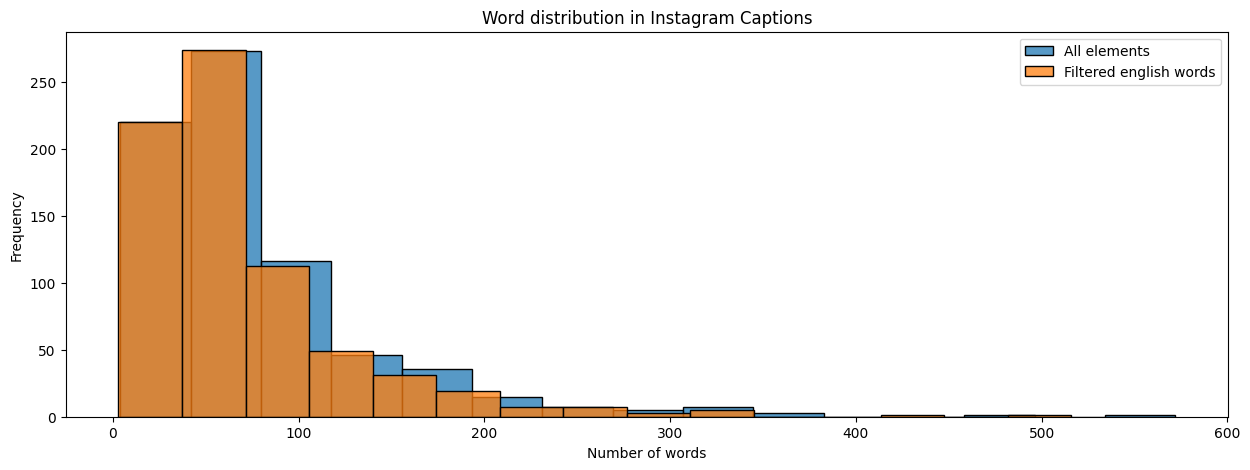

In [33]:
# Get the count of all comments and sort it
all_words_counts = review_df_train["text"].dropna().apply(lambda x: len("\n".join(x).split())).to_numpy()
all_words_counts.sort()

# Get the count of filtered ONLY English comments and sort it
english_words_counts = review_df_train["text"].dropna().apply(lambda x: len(filter_english_comment("\n".join(x)).split())).to_numpy()
english_words_counts.sort()

plt.figure(figsize=(15, 5))
sns.histplot(all_words_counts, bins=15, label="All elements")
sns.histplot(english_words_counts, bins=15, label="Filtered english words")

plt.title("Word count distribution in SemEval")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.legend()
plt.savefig('/kaggle/working/count_review_len_distribution.png')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


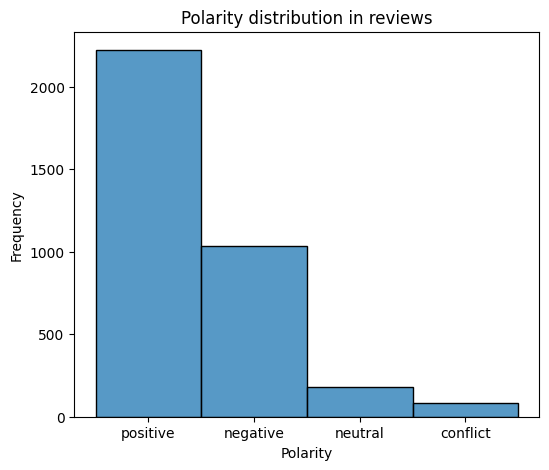

In [55]:
plt.figure(figsize=(6, 5))
sns.histplot(opinions_df_train.polarity)
plt.title("Polarity distribution in reviews")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.savefig('/kaggle/working/polarity_review_distribution.png')

In [56]:
def compose_subcategories_df(options_df):
    df = options_df.copy()
    df["polarity"] = df["polarity"].replace({"positive": 1, "negative": 0, "neutral": 0.5, "conflict": 0.5})
    df = df.groupby(["review_id", "subcategory"])["polarity"].mean().reset_index()
    df["polarity"] = df["polarity"].fillna(0.5) # replace with neutral
    df = df[["review_id", "subcategory", "polarity"]]
    return df

opinions_df_train_ = compose_subcategories_df(opinions_df_train)
opinions_df_eval_ = compose_subcategories_df(opinions_df_eval)

/tmp/ipykernel_33/319917118.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["polarity"] = df["polarity"].replace({"positive": 1, "negative": 0, "neutral": 0.5, "conflict": 0.5})
/tmp/ipykernel_33/319917118.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["polarity"] = df["polarity"].replace({"positive": 1, "negative": 0, "neutral": 0.5, "conflict": 0.5})


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


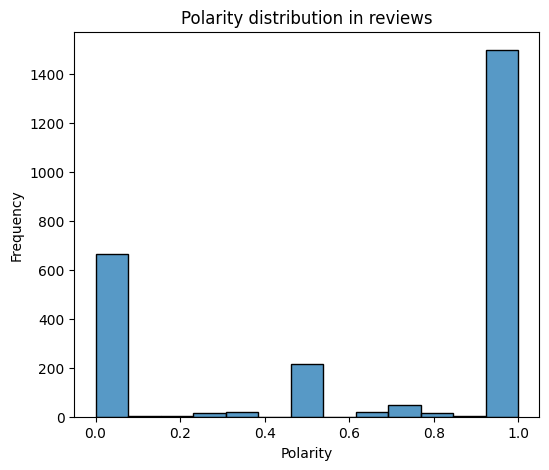

In [57]:
plt.figure(figsize=(6, 5))
sns.histplot(opinions_df_train_.polarity)
plt.title("Polarity distribution in reviews")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.savefig('/kaggle/working/polarity_review_distribution_new.png')

In [9]:
def compose_labeled_df(review_df, options_df):
    label_columns = [
        name
        for subcategory in options_df.subcategory.unique()
        for name in (subcategory + "_pos", subcategory + "_neg")
    ]
    label_columns.remove("PRICES_pos")
    label_columns.remove("PRICES_neg")
    
    labeled_df = pd.DataFrame(columns=["review_id", "text", *label_columns])
    labeled_df[label_columns] = labeled_df[label_columns].astype(float)
    labeled_df["review_id"] = review_df["review_id"].copy()
    labeled_df["text"] = review_df["text"].apply(lambda x: "\n".join(x))
    with pd.option_context("future.no_silent_downcasting", True):
        labeled_df.fillna(0, inplace=True)
    labeled_df = labeled_df.set_index('review_id')

    for subcategory in options_df.subcategory.unique():
        pos_op = options_df[(options_df["subcategory"] == subcategory) & (options_df["polarity"] == "positive")]
        neg_op = options_df[(options_df["subcategory"] == subcategory) & (options_df["polarity"] == "negative")]
        # neut_op = options_df[(options_df["subcategory"] == subcategory) & (options_df["polarity"] == "neutral")]
        conf_op = options_df[(options_df["subcategory"] == subcategory) & (options_df["polarity"] == "conflict")]
        
        if subcategory == "PRICES":
            subcategory = "PRICE"
        
        labeled_df.loc[pos_op.review_id, subcategory + "_pos"] += 1
        labeled_df.loc[neg_op.review_id, subcategory + "_neg"] += 1
        labeled_df.loc[conf_op.review_id, subcategory + "_pos"] += 0.5
        labeled_df.loc[conf_op.review_id, subcategory + "_neg"] += 0.5

    # Normalize the counts for each subcategory so that they sum up to 1
    for subcategory in options_df.subcategory.unique():
        if subcategory == "PRICES":
            subcategory = "PRICE"

        pos_sum = labeled_df[subcategory + "_pos"] + labeled_df[subcategory + "_neg"]
        pos_sum[pos_sum == 0] = 1.
        labeled_df[subcategory + "_pos"] /= pos_sum
        labeled_df[subcategory + "_neg"] /= pos_sum
        
    labeled_df.reset_index(drop=True, inplace=True)
    return labeled_df

In [10]:
train_data = compose_labeled_df(review_df_train, opinions_df_train)
eval_data = compose_labeled_df(review_df_eval, opinions_df_eval)

subcategories = list(opinions_df_train.subcategory.unique())
subcategories.remove("PRICES")

eval_data.head()

,text,GENERAL_pos,GENERAL_neg,OPERATION_PERFORMANCE_pos,OPERATION_PERFORMANCE_neg,DESIGN_FEATURES_pos,DESIGN_FEATURES_neg,QUALITY_pos,QUALITY_neg,USABILITY_pos,...,PRICE_pos,PRICE_neg,CONNECTIVITY_pos,CONNECTIVITY_neg,PORTABILITY_pos,PORTABILITY_neg,STYLE_OPTIONS_pos,STYLE_OPTIONS_neg,MISCELLANEOUS_pos,MISCELLANEOUS_neg
0,Most everything is fine with this machine: spe...,1.0,0.0,1.0,0.0,1.0,0.0,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"I love the size, keyboard, the functions.\nI d...",1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,I love this product because it is Toshiba and ...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I bought this laptop Was the worst Laptop I've...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"So far, a great product.\nHigh price tag, howe...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

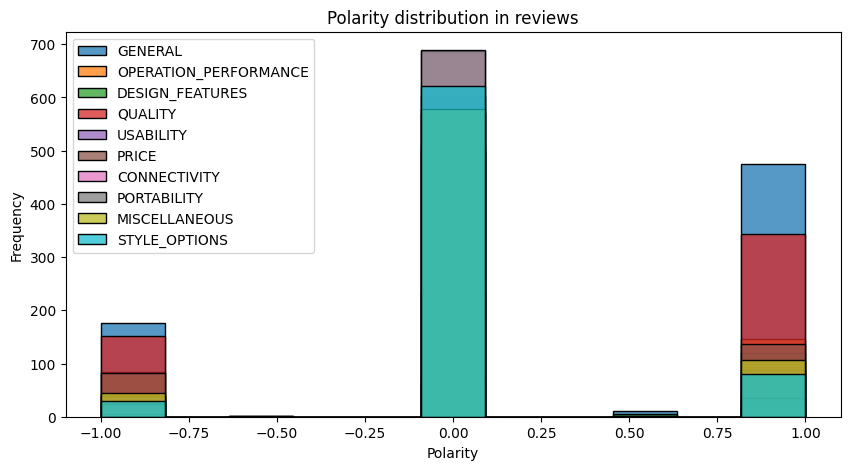

In [94]:
plt.figure(figsize=(10, 5))

for subcategory in subcategories:
    delta_col = train_data[subcategory + "_pos"] - train_data[subcategory + "_neg"]
    sns.histplot(delta_col, label = subcategory)

plt.legend()
plt.title("Polarity distribution in reviews")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.savefig('/kaggle/working/polarity_subcategory_distribution.png')

Visibly, the distribution is significantly uneven, even between subcategories. So we'll need to get the right weights for the categories.

In [13]:
weights_in_categories = []
weight_categories = []

for subcategory in subcategories:
    positive_ones = sum(train_data[subcategory + "_pos"] > 0)
    negative_ones = sum(train_data[subcategory + "_neg"] > 0)
    weights_in_categories.append([positive_ones, negative_ones])
    weight_categories.append(sum((train_data[subcategory + "_pos"] != 0) | (train_data[subcategory + "_neg"] != 0)))

weights_in_categories = np.array(weights_in_categories)
weight_categories = np.array(weight_categories)

/tmp/ipykernel_32/3939145129.py:2: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  column_names = pd.unique(list(map(lambda x: x[:5], subcategories)))


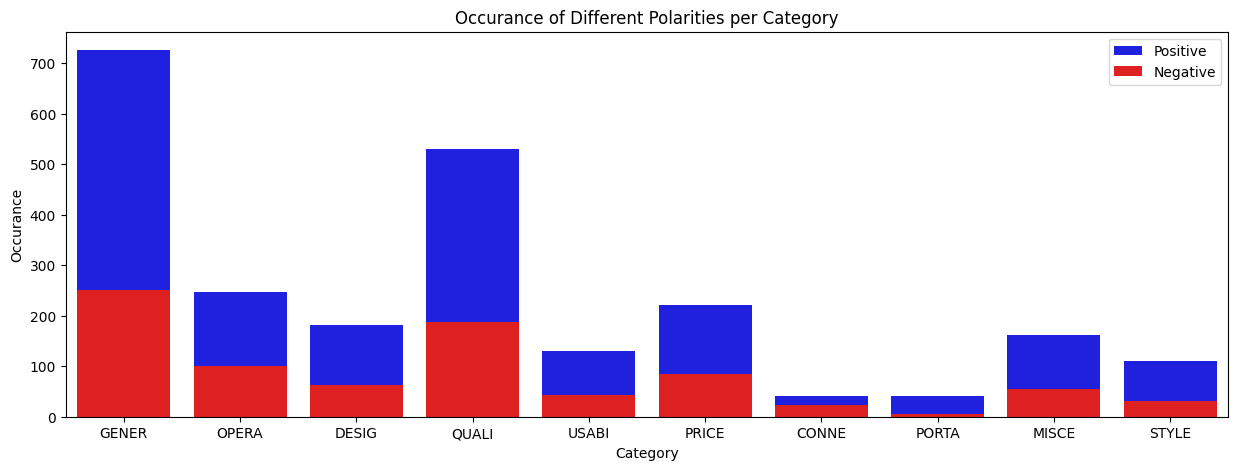

In [100]:
fig, ax = plt.subplots(figsize=(15, 5))
column_names = pd.unique(list(map(lambda x: x[:5], subcategories)))
# Plot the positive and negative weights for each category
sns.barplot(x=column_names, y=weight_categories, color="blue", label="Positive")
sns.barplot(x=column_names, y=weights_in_categories[:, 1], color="red", label="Negative")

plt.legend()
plt.title("Occurance of Different Polarities per Category")
plt.xlabel("Category")
plt.ylabel("Occurance")
plt.savefig('/kaggle/working/pos_neg_subcategory_distribution.png')

Clearly there are categories with almost no examples, like CONNECTIVITY and PORTABILITY. Both make sense only with specific types of product, so they are not as general as we possibly would like them. So let's get rid of them for the sake of getting a fine model.

In [11]:
for subcategory in ["CONNECTIVITY", "PORTABILITY"]:
    train_data.drop(columns = [subcategory + "_pos", subcategory + "_neg"], inplace=True)
    eval_data.drop(columns = [subcategory + "_pos", subcategory + "_neg"], inplace=True)
train_data.to_csv("/kaggle/working/train_data.csv",index=False)
eval_data.to_csv("/kaggle/working/eval_data.csv", index=False)

subcategories.remove("CONNECTIVITY")
subcategories.remove("PORTABILITY")

In [22]:
pos_weights = []
weight_categories = []

# subcategories = config.categories
for subcategory in subcategories:
    positive_ones = sum(train_data[subcategory + "_pos"] > 0.5)
    negative_ones = sum(train_data[subcategory + "_neg"] > 0.5)
    weight_categories.append(positive_ones)
    weight_categories.append(negative_ones)
    # weight_categories.append(sum((train_data[subcategory + "_pos"] != 0) | (train_data[subcategory + "_neg"] != 0)))

pos_weights = np.array(weight_categories) / train_data.shape[0]
weight_categories = np.array(weight_categories, dtype=float) / sum(weight_categories)
pos_weights = 1. / pos_weights
pos_weights

array([ 1.50515464,  4.07821229,  5.        ,  8.69047619,  5.88709677,
       19.21052632,  2.11594203,  4.77124183,  8.20224719, 19.21052632,
        5.32846715,  8.90243902,  6.82242991, 16.22222222,  9.125     ,
       25.17241379])

## Model

Now we're pretty ready to start the main part - building a model to predict all this. Obviously we'll use the same text tokenizer as for captions/tweets, even though text in these reviews is a lot cleaner. Since we'll most likely majorly work with 50-word texts, I think it's relatively objective to apply a small pretrained BERT model on those with a few linear layers to grasp the polarity. The task we're now doing is basically multilabeling for subcategories. And since that's the case, we can use the traditional approach that uses the last output for classifier. Also since I decided out of three models to use smaller one, we'll apply mean average to get embedding. As for the classifier, it's traditional that for each label we'll have a seperate final layer. Considering that technically for each label we have two outputs, we redesigned that to predict pairs of positive/negative polarities seperately for labels.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import transformers
from transformers import BertModel, AutoTokenizer, get_scheduler

from datetime import datetime

In [44]:
# let's say we put multilabel binary classification. The various labels are differently weighted.
# The different positive and negative are also differently weighted

weight = torch.tensor([1, 1, 1])
pos_weight = torch.tensor([2.0, 3.0, 4.0])

# BCEWithLogitsLoss with pos_weight
criterion = nn.BCEWithLogitsLoss(weight=weight, pos_weight=pos_weight)

# Inputs and labels
logits1 = torch.tensor([[0.8, 0, 0], [0, 0, 1], [0, 1, 1], [1, 1, 1]], dtype=torch.float)
logits2 = torch.tensor([[0, 0.8, 0], [0, 0, 1], [0, 1, 1], [1, 1, 1]], dtype=torch.float)
logits3 = torch.tensor([[0, 0, 0.8], [0, 0, 1], [0, 1, 1], [1, 1, 1]], dtype=torch.float)
logits4 = torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 1], [0.2, 1, 1]], dtype=torch.float)
logits5 = torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 1], [1, 0.2, 1]], dtype=torch.float)
logits6 = torch.tensor([[0, 0, 0], [0, 0, 1], [0, 1, 1], [1, 1, 0.2]], dtype=torch.float)

labels = torch.tensor([[0, 0, 0], [0, 0, 1], [0, 0.5, 1], [1, 1, 1]], dtype=torch.float)

print("Criterion 1: ", criterion(logits1, labels) - criterion(labels, labels))
print("Criterion 2: ", criterion(logits2, labels) - criterion(labels, labels))
print("Criterion 3: ", criterion(logits3, labels) - criterion(labels, labels))
print("Criterion 4: ", criterion(logits4, labels) - criterion(labels, labels))
print("Criterion 5: ", criterion(logits5, labels) - criterion(labels, labels))
print("Criterion 6: ", criterion(logits6, labels) - criterion(labels, labels))

Criterion 1:  tensor(0.0339)
Criterion 2:  tensor(0.0339)
Criterion 3:  tensor(0.0339)
Criterion 4:  tensor(0.0415)
Criterion 5:  tensor(0.0653)
Criterion 6:  tensor(0.0890)


In [6]:
from dataclasses import dataclass
from typing import List
import pickle

@dataclass
class Config:
    train_data_path: str = "/kaggle/input/semeval-2016-task-5-absa/train_data.csv"
    eval_data_path: str = "/kaggle/input/semeval-2016-task-5-absa/eval_data.csv"
    pos_weights: List[float] = None # pos_weights
    weight_categories: List[float] = None # weight_categories
    categories: List[str] = None # tuple(subcategories)
    checkpoint_path: str = "/kaggle/working"
    output_path: str = "/kaggle/working/instagram_semantics.xml"
    batch_size: int = 64
    pin_memory: bool = False
    num_workers: int = 2
    seed: int = 666
    lr: float = 1e-2
        
    def save(self, path):
        with open(path, "wb") as f:
            pickle.dump(self.__dict__.items(), f)

    @classmethod
    def load(cls, path):
        my_model = {}
        for name in cls.__annotations__:
            with open(path, "rb") as f:
                my_model[name] = pickle.load(f)[name]
        return cls(**my_model)

path_save = "/kaggle/working/config.pkl"
with open(path_save, "wb") as f:
    pickle.dump(Config(), f)
    
path_load = "/kaggle/input/semeval-2016-task-5-absa/config.pkl"
with open(path_load, "rb") as f:
    config = pickle.load(f)

In [7]:
import os
if os.path.exists(config.train_data_path):
    train_data = pd.read_csv(config.train_data_path)
if os.path.exists(config.eval_data_path):
    eval_data = pd.read_csv(config.eval_data_path)

In [8]:
class SemeEvalDataset(Dataset):
    def __init__(self, reviews_df, tokenizer, label_cols, text_col="text", max_sequence_len=512, as_float=False): 
        self.as_float = as_float
        print(f'({datetime.now()}) Starting Process')
        self.labels = torch.tensor(reviews_df[label_cols].values)
        self.n_examples = len(self.labels)
        print(f'({datetime.now()}) Using tokenizer on all texts')
        texts = list(reviews_df[text_col].values)
        self.inputs = tokenizer(texts, add_special_tokens=True,
                                truncation=True, padding=True,
                                return_tensors='pt',
                                max_length = max_sequence_len)

        self.sequence_len = self.inputs['input_ids'].shape[-1]
        print(f'({datetime.now()}) Texts padded or truncated to {self.sequence_len} length.')
        print(f'({datetime.now()}) Finished!\n')

    def __len__(self):
        return self.n_examples

    def __getitem__(self, i):
        if self.as_float:
            return {key: self.inputs[key][i] for key in self.inputs.keys()}, self.labels[i].to(torch.float)
        else:
            return {key: self.inputs[key][i] for key in self.inputs.keys()}, self.labels[i]

model_id = "sentence-transformers/all-MiniLM-L6-v2"
        # "browndw/docusco-bert" - unfortunately certain weights failed to load from checkpoint
        # "bert-base-uncased" - unfortunately too large
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512

label_columns = [
    name
    for subcategory in config.categories
    for name in (subcategory + "_pos", subcategory + "_neg")
]

train_dataset = SemeEvalDataset(
    reviews_df=train_data,
    tokenizer=tokenizer,
    text_col="text",
    label_cols=label_columns,
    max_sequence_len=512,
    as_float=True
)

eval_dataset = SemeEvalDataset(
    reviews_df=eval_data,
    tokenizer=tokenizer,
    text_col="text",
    label_cols=label_columns,
    max_sequence_len=512,
    as_float=True
)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

(2024-05-13 13:07:36.969789) Starting Process
(2024-05-13 13:07:37.008952) Using tokenizer on all texts
(2024-05-13 13:07:37.503558) Texts padded or truncated to 512 length.
(2024-05-13 13:07:37.503642) Finished!

(2024-05-13 13:07:37.503783) Starting Process
(2024-05-13 13:07:37.504899) Using tokenizer on all texts
(2024-05-13 13:07:37.514836) Texts padded or truncated to 315 length.
(2024-05-13 13:07:37.514862) Finished!



In [9]:
train_loader = DataLoader(train_dataset, config.batch_size, shuffle=True,
                          num_workers=config.num_workers, 
                          pin_memory=config.pin_memory)
val_loader = DataLoader(eval_dataset, config.batch_size, shuffle=False, 
                        num_workers=config.num_workers, 
                        pin_memory=config.pin_memory)

In [13]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


class ABSABert(nn.Module):
    def __init__(self, bert, mid_dim = 256, num_labels = 10): # output would be num_labels * 2
        super(ABSABert, self).__init__()
        self.bert = bert
        self.num_labels = num_labels
        self.processing = nn.Sequential(nn.Dropout(p=0.1), nn.Linear(384, mid_dim), nn.ReLU())
        
        self.class_classifiers = {}
        for i in range(self.num_labels):
            self.class_classifiers[i] = nn.Sequential(nn.Linear(mid_dim, 2), nn.Sigmoid())
            
    def to(self, device):
        for i, classifier in self.class_classifiers.items():
            self.class_classifiers[i] = classifier.to(device)
        return super().to(device)
    
    def get_trainable(self):
        state_dict = {}
        for i, classifier in enumerate(self.class_classifiers):
            state_dict[i] = classifier.state_dict()
        state_dict["processing"] = self.processing.state_dict()
    
    def load_trainable(self, state_dict):
        for i, classifier in enumerate(self.class_classifiers):
            classifier.load_state_dict(state_dict[i])
        self.processing.load_state_dict(state_dict["processing"])

    def forward(self, input_ids, token_type_ids, attention_mask): 
        # -> batch_size x (num_labels * 2)
        with torch.no_grad():
            pooled_output = self.bert(input_ids, token_type_ids, attention_mask, 
                                         return_dict=False)
        # mean_pooling --!
        sentence_embeddings = mean_pooling(pooled_output, attention_mask)
        # Normalize embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        
        processed = self.processing(sentence_embeddings)
        logits = torch.cat([classifier(processed) for classifier in self.class_classifiers.values()], dim = 1)
        return logits

bert = BertModel.from_pretrained(model_id)

In [11]:
def plot_losses_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the losses
    ax1.plot([h['train_loss'] for h in history], label='Training loss')
    ax1.plot([h['val_loss'] for h in history], label='Validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot the accuracy
    ax2.plot([h['train_acc'] for h in history], label='Training accuracy')
    ax2.plot([h['val_acc'] for h in history], label='Validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.savefig('/kaggle/working/history.png')

In [18]:
from torchmetrics.classification import BinaryAccuracy
from time import perf_counter
from tqdm import tqdm
from typing import Any, Dict

def save_checkpoint(epoch, model, optimizer, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, path)

def load_checkpoint(model, optimizer, path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(path, map_location=device)
    epoch = checkpoint["epoch"]
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return epoch

def train(model,
          train_dataloader,
          val_dataloader,
          learning_rate,
          losses : Dict[float, Any],
          epochs : int,
          checkpoint_path : str):
    start = perf_counter()
    history = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    model = model.to(device)
    for weight, loss in losses.items():
        losses[weight] = loss.to(device)
    criterion = lambda outputs, labels: sum([weight*loss(outputs, labels) for weight, loss in losses.items()])

    accuracy_estimator = BinaryAccuracy(multidim_average="global").to(device)
    
    all_params = list(model.parameters())
    for classifier in model.class_classifiers.values():
        all_params += list(classifier.parameters())
    optimizer = optim.AdamW(all_params, lr=learning_rate)
    num_training_steps = epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer, 
        num_warmup_steps=1,
        num_training_steps=num_training_steps
    )

    for epoch_num in range(epochs):
        epoch_start = perf_counter()
        total_acc_train = 0
        total_loss_train = 0

        model.train()
        for inputs, semantics in tqdm(train_dataloader, desc=f"Epoch {epoch_num+1}"):
            semantics = semantics.to(device) # .to(torch.long)

            inputs['attention_mask'] = inputs['attention_mask'].to(device)
            inputs['input_ids'] = inputs['input_ids'].to(device)
            inputs['token_type_ids'] = inputs['token_type_ids'].to(device)

            outputs = model(**inputs)

            # loss
            loss = criterion(outputs, semantics)
            loss.backward()

            # collate losses and acc.
            total_loss_train += loss.item()
            acc = accuracy_estimator(outputs, torch.round(semantics)).item()
            total_acc_train += acc

            # Update step
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # saving checkpoint
        if epoch_num > 5 and epoch_num%2 == 0:
            path = checkpoint_path + f"/absa_epoch_{epoch_num}.pt"
            save_checkpoint(epoch_num, model, optimizer, path)

        # Validation Phase
        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        with torch.no_grad():
            for val_input, semantics in val_dataloader:
                semantics = semantics.to(device)
                val_input['attention_mask'] = val_input['attention_mask'].to(device)
                val_input['input_ids'] = val_input['input_ids'].to(device)
                val_input['token_type_ids'] = val_input['token_type_ids'].to(device)

                outputs = model(**val_input)

                batch_loss = criterion(outputs, semantics)
                total_loss_val += batch_loss.item()
                acc = accuracy_estimator(outputs, torch.round(semantics)).item()
                total_acc_val += acc

        # measure epoch-time        
        epoch_time = perf_counter() - epoch_start

        # print results
        print(f'\nEpochs: {epoch_num + 1}/{epochs} | Train Loss: {total_loss_train / len(train_dataloader): .3f} \
| Train Accuracy: {total_acc_train / len(train_dataloader): .3f} | Val Loss: {total_loss_val / len(val_dataloader): .3f} \
| Val Accuracy: {total_acc_val / len(val_dataloader): .3f} | Epoch Time: {epoch_time//60:.0f}m {epoch_time%60:.2f}s')

        # store results
        result = {'epoch': epoch_num + 1, 
                  'train_loss': total_loss_train / len(train_dataloader),
                  'train_acc': total_acc_train / len(train_dataloader),
                  'val_loss': total_loss_val / len(val_dataloader),
                  'val_acc': total_acc_val / len(val_dataloader),
                  'epoch_time': epoch_time
                 }
        history.append(result)
    
    time_taken = perf_counter() - start
    print(f"\nTime Taken to train the model: {time_taken//60:.0f}m {time_taken%60:.2f}s")
    
    return history

Epoch 1: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]



Epochs: 1/10 | Train Loss:  0.930 | Train Accuracy:  0.665 | Val Loss:  0.876 | Val Accuracy:  0.825 | Epoch Time: 0m 5.82s


Epoch 2: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]



Epochs: 2/10 | Train Loss:  0.924 | Train Accuracy:  0.830 | Val Loss:  0.860 | Val Accuracy:  0.834 | Epoch Time: 0m 5.92s


Epoch 3: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]



Epochs: 3/10 | Train Loss:  0.904 | Train Accuracy:  0.833 | Val Loss:  0.847 | Val Accuracy:  0.828 | Epoch Time: 0m 5.97s


Epoch 4: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]



Epochs: 4/10 | Train Loss:  0.902 | Train Accuracy:  0.831 | Val Loss:  0.841 | Val Accuracy:  0.828 | Epoch Time: 0m 6.01s


Epoch 5: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]



Epochs: 5/10 | Train Loss:  0.894 | Train Accuracy:  0.834 | Val Loss:  0.839 | Val Accuracy:  0.825 | Epoch Time: 0m 5.90s


Epoch 6: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]



Epochs: 6/10 | Train Loss:  0.900 | Train Accuracy:  0.831 | Val Loss:  0.839 | Val Accuracy:  0.825 | Epoch Time: 0m 5.82s


Epoch 7: 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]



Epochs: 7/10 | Train Loss:  0.894 | Train Accuracy:  0.830 | Val Loss:  0.838 | Val Accuracy:  0.816 | Epoch Time: 0m 5.97s


Epoch 8: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]



Epochs: 8/10 | Train Loss:  0.888 | Train Accuracy:  0.831 | Val Loss:  0.838 | Val Accuracy:  0.816 | Epoch Time: 0m 5.66s


Epoch 9: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]



Epochs: 9/10 | Train Loss:  0.888 | Train Accuracy:  0.832 | Val Loss:  0.838 | Val Accuracy:  0.816 | Epoch Time: 0m 5.85s


Epoch 10: 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]



Epochs: 10/10 | Train Loss:  0.889 | Train Accuracy:  0.830 | Val Loss:  0.838 | Val Accuracy:  0.816 | Epoch Time: 0m 5.56s

Time Taken to train the model: 0m 58.49s


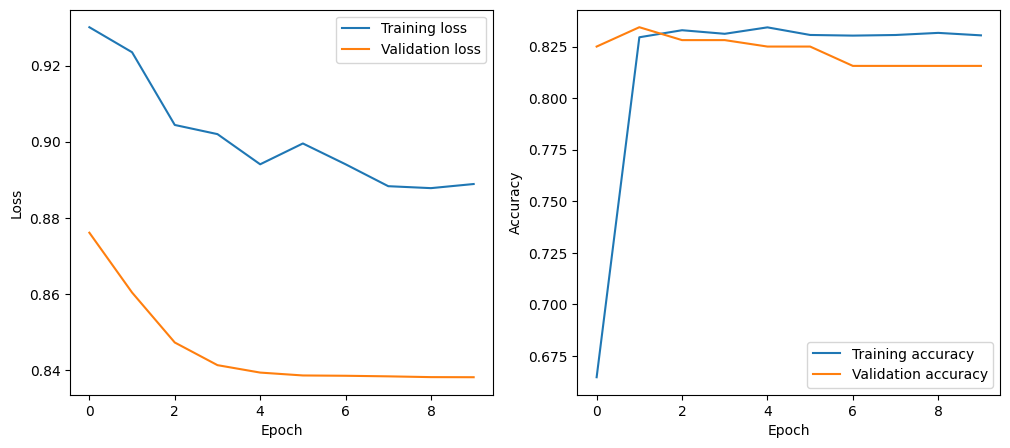

In [24]:
model = ABSABert(bert, num_labels = len(config.categories))
# for param in model.bert.parameters():
#    param.requires_grad = False # WE ARE NOT GOING TO TRAIN BERT

os.environ["TOKENIZERS_PARALLELISM"] = "false"

losses = { # weight: loss
    0.7 : nn.BCEWithLogitsLoss(pos_weight = torch.tensor(config.pos_weights)),
    0.3 : nn.HuberLoss(delta = 0.25)
}
# nn.HuberLoss()
# nn.BCELoss(weight = torch.tensor(weights)) 
# nn.CrossEntropyLoss()

history = train(
    model = model,
    train_dataloader = train_loader,
    val_dataloader = val_loader,
    learning_rate = 1e-3, # config.lr,
    epochs = 10,
    losses = losses,
    checkpoint_path = '/kaggle/working'
)
plot_losses_accuracy(history)

Epoch 1: 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]



Epochs: 1/10 | Train Loss:  1.164 | Train Accuracy:  0.693 | Val Loss:  1.090 | Val Accuracy:  0.791 | Epoch Time: 0m 5.36s


Epoch 2: 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]



Epochs: 2/10 | Train Loss:  1.151 | Train Accuracy:  0.802 | Val Loss:  1.078 | Val Accuracy:  0.816 | Epoch Time: 0m 5.36s


Epoch 3: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]



Epochs: 3/10 | Train Loss:  1.142 | Train Accuracy:  0.824 | Val Loss:  1.073 | Val Accuracy:  0.819 | Epoch Time: 0m 5.40s


Epoch 4: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]



Epochs: 4/10 | Train Loss:  1.125 | Train Accuracy:  0.825 | Val Loss:  1.071 | Val Accuracy:  0.819 | Epoch Time: 0m 5.43s


Epoch 5: 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]



Epochs: 5/10 | Train Loss:  1.133 | Train Accuracy:  0.819 | Val Loss:  1.069 | Val Accuracy:  0.819 | Epoch Time: 0m 5.47s


Epoch 6: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]



Epochs: 6/10 | Train Loss:  1.129 | Train Accuracy:  0.821 | Val Loss:  1.068 | Val Accuracy:  0.816 | Epoch Time: 0m 5.51s


Epoch 7: 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]



Epochs: 7/10 | Train Loss:  1.133 | Train Accuracy:  0.818 | Val Loss:  1.068 | Val Accuracy:  0.819 | Epoch Time: 0m 5.76s


Epoch 8: 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]



Epochs: 8/10 | Train Loss:  1.129 | Train Accuracy:  0.818 | Val Loss:  1.068 | Val Accuracy:  0.812 | Epoch Time: 0m 5.51s


Epoch 9: 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]



Epochs: 9/10 | Train Loss:  1.128 | Train Accuracy:  0.817 | Val Loss:  1.068 | Val Accuracy:  0.809 | Epoch Time: 0m 5.69s


Epoch 10: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]



Epochs: 10/10 | Train Loss:  1.125 | Train Accuracy:  0.817 | Val Loss:  1.068 | Val Accuracy:  0.806 | Epoch Time: 0m 5.42s

Time Taken to train the model: 0m 54.94s


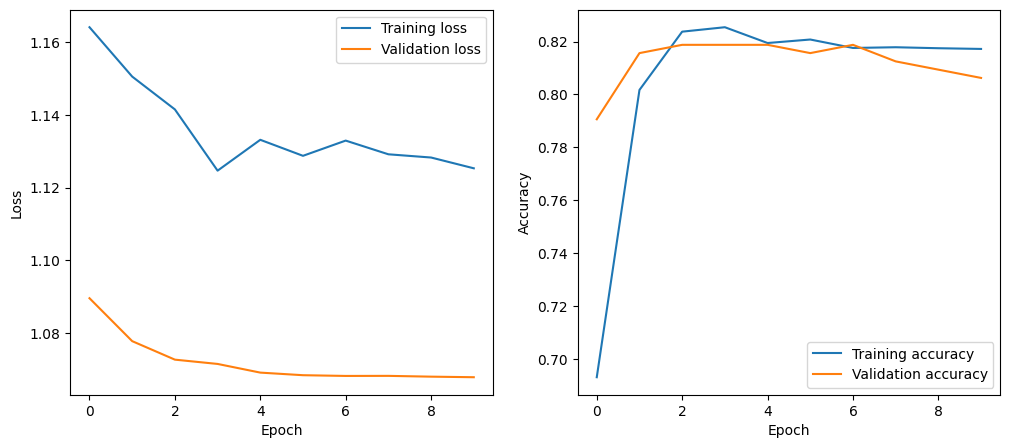

In [48]:
model = ABSABert(bert, num_labels = len(config.categories))
# for param in model.bert.parameters():
#    param.requires_grad = False # WE ARE NOT GOING TO TRAIN BERT

os.environ["TOKENIZERS_PARALLELISM"] = "false"

losses = { # weight: loss
    0.9 : nn.BCEWithLogitsLoss(pos_weight = torch.tensor(config.pos_weights)),
    0.1 : nn.HuberLoss(delta = 0.25)
}
# nn.HuberLoss()
# nn.BCELoss(weight = torch.tensor(weights)) 
# nn.CrossEntropyLoss()

history = train(
    model = model,
    train_dataloader = train_loader,
    val_dataloader = val_loader,
    learning_rate = 1e-2, # config.lr,
    epochs = 10,
    losses = losses,
    checkpoint_path = '/kaggle/working'
)
plot_losses_accuracy(history)

In [41]:
train_data[train_data["PRICE_pos"] == 1].text.iloc[:10]

1     I love the size, keyboard, the functions.\nI d...
5     This laptop is a great price and has a sleek l...
7     Great price and computer!\nI bought this lapto...
17    Very good quality and well made.\nGreat pick f...
20    If you need an affordable, entry-level laptop,...
22    the laptop was really good and it goes really ...
27    The Toshiba laptop was a great purchase.\nThe ...
31    I purchased two laptops (for my husband and 16...
39    This laptop serves all my needs.\nScreen size ...
54    Like the price and operation.\nSome features a...
Name: text, dtype: object

In [49]:
def run_model(text):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        inputs = tokenizer(text, add_special_tokens=True,
                truncation=True, padding=True,
                return_tensors='pt',
                max_length = 512).to(device)
        outputs = model(**inputs).to("cpu")[0].tolist()
        result = {category : (outputs[2*i], outputs[2*i+1]) for i, category in enumerate(config.categories)}
        print(result["PRICE"])

run_model("I loved that pizza, plus it's super cheap!")
run_model("I loved that pizza, but the service was awful!")
run_model("I loved that pizza. The quality was awesome!")
run_model("Great price and computer!")
run_model("A bit pricy, but the taste is good.")
run_model("What a fucking failure, it's not worth a dollar!")
run_model("Why such price? It's low grade shit cooked by slaves")

(0.5112406611442566, 0.44576355814933777)
(0.49495604634284973, 0.4807627499103546)
(0.4676455855369568, 0.4502182602882385)
(0.46199482679367065, 0.4843270182609558)
(0.5349754095077515, 0.47775763273239136)
(0.5504827499389648, 0.5664955973625183)
(0.5317755937576294, 0.5308826565742493)


In [50]:
for text in train_data[train_data["PRICE_pos"] == 1].text.iloc[:3]:
    print("----------------------")
    print(text)
    run_model(text)
for text in train_data[train_data["PRICE_neg"] == 1].text.iloc[:3]:
    print("----------------------")
    print(text)
    run_model(text)

----------------------
I love the size, keyboard, the functions.
I don't really have a complaint.
It is easy to use, good quality and good price.
Perfect trifecta!
I would recommend this product.
(0.5010291337966919, 0.5048193335533142)
----------------------
This laptop is a great price and has a sleek look.
Runs smooth and quick.
I wish it had a webcam though, then it would be perfect!
(0.534988284111023, 0.4557810425758362)
----------------------
Great price and computer!
I bought this laptop computer for my parents, they only access their facebook and e-mail accounts, see family pictures, etc.
They loved it.
It's easy to operate and it's very light (my parents are almost 60 yo, they can't carry a heavy computer while traveling).
But here's something I hadn't realized before buying it: there isn't an optical drive, which means NO CDs or DVDs!
(0.5397257804870605, 0.49343302845954895)
----------------------
I bought this laptop Was the worst Laptop I've ever bought.
I spent alot of m

In [51]:
torch.save(model, '/kaggle/working/absa_lstm_best.pt')

In [ ]:
!pip install demoji
from bs4 import BeautifulSoup
import contractions
import demoji


def html_remover(data):
    beauti = BeautifulSoup(data,'html.parser')
    return beauti.get_text()

def contraction_replace(data):
    return contractions.fix(data)

def number_to_text(data):
    temp_str = data.split()
    string = []
    for i in temp_str:
        # if the word is digit, converted to 
        # word else the sequence continues
        if i.isdigit():
            temp = inflect.engine().number_to_words(i)
            string.append(temp)
        else:
            string.append(i)
    return " ".join(string)

def remove_punc(data):
    trans = str.maketrans('','', string.punctuation)
    return data.translate(trans)

def white_space(data):
    return ' '.join(data.split())

def handle_emoji(text):
    emojis = demoji.findall(text)
    for emoji in emojis:
        string = text.replace(emoji, " " + emojis[emoji].split(":")[0])
    return text

def remove_emoji(text):
    text = demoji.replace(text, "")
    return text

def basic_clean_text_from_special(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) # remove mentions
    text = re.sub(r"#[A-Za-z0-9_]+", "", text) # remove hashtags
    text = re.sub(r"RT[\s]+", "", text) # remove retweets
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) # remove links
    return text

def clean_text_from_special(text, replace_emoji = False):
    text = basic_clean_text_from_special(text)
    if remove_emoji:
        text = handle_emoji(text) # replace emoji with words
    else:
        text = remove_emoji(text) # remove emoji
    text = re.sub('\(.*?\)','',text) # remove round brackets
    return text

def preprocess_text(text, replace_emoji = False):
    # remove old style retweet text "RT"
    text = clean_text_from_special(text, replace_emoji)
    text = html_remover(text) # remove <bs> and such
    text = contraction_replace(text) # replace contractions
    text = number_to_text(text) # replace numbers
    # text = white_space(text) # remove unnecessary \n and whitespaces
    # text = remove_punc(text) # remove punkt
    return text

def vader_clear_text(text):
    return basic_clean_text_from_special(text)

In [ ]:
def preprocess_comments(comments: str, min_length = 10, max_length = 1000, max_number = 400):
    # we'll filter short as well as too long comments
    short_comments = filter(lambda x: len(x) > min_length and len(x) < max_length, comments.split("\n"))
    filtered_comments = list(short_comments)[:max_number]
    return list(map(basic_clean_text_from_special, filtered_comments))

class InstagramDataset(Dataset):
    def __init__(
        self,
        posts_df,
        tokenizer,
        caption_col = "caption",
        comments_col = "comments",
        max_sequence_len=512,
        as_float=False
    ):
        self.as_float = as_float
        print(f'({datetime.now()}) Starting Process')
        self.comments = posts_df[comments_col].apply(preprocess_comments)
        self.n_examples = posts_df.shape
        print(f'({datetime.now()}) Using tokenizer on captions')
        texts = list(reviews_df[text_col].values)
        self.captions = tokenizer(posts_df[caption_col].apply(preprocess_text),
                                add_special_tokens=True,
                                truncation=True, padding=True,
                                return_tensors='pt',
                                max_length = max_sequence_len)

        self.sequence_len = self.inputs['input_ids'].shape[-1]
        print(f'({datetime.now()}) Texts padded or truncated to {self.sequence_len} length.')
        print(f'({datetime.now()}) Finished!\n')

    def __len__(self):
        return self.n_examples

    def __getitem__(self, i):
        return {"captions" : {key: self.captions[key][i] for key in self.captions.keys()}, "comments" : torch.tensor(self.comments[i])}

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

class InstagramPostModel:
    def __init__(self, tokenizer, absa_model_checkpoint_path: str):
        self.comment_analyzer = SentimentIntensityAnalyzer()
        
    def forward(self, df, comment_col="", )

def sentiment_analysis_vader(df, analyzer):
    target_col = 'text'
    prefix = 'vader_'

    scores_col = prefix+'scores'
    compound_col = prefix+'polarity'
    comp_score_col = prefix+'sentiment' 

    df[scores_col] = df[target_col].apply(lambda text: analyzer.polarity_scores(text))
    df[compound_col] = df[scores_col].apply(lambda d: (d['compound'] + 1)/2)
    return df
    

df = pd.DataFrame({'clean_text': all_tweets, "true_polarity": [*([1]*5000), *([0]*5000)]})
sentiment_analysis_vader(df, analyzer, clean=True)

### Here goes an attempt to use another absa dataset, an unfortunate one
(Apparently there're a lot more datasets on topic of sentiment analysis based on core identities taken directly from sentence. So instead of a topic, there's a sequence of words from the sentence and sentiment regarding them)

In [5]:
!ls /kaggle/input/absa-dataset/Stanford/Stanford
!ls /kaggle/input/absa-dataset/allennlp    
!ls /kaggle/input/absa-dataset/stanza    
!ls /kaggle/input/absa-dataset/Stanford/Stanford/Restaurants     

Laptops  Restaurants  Restaurants16  Tweets
Laptops_allennlp  Restaurants_allennlp	Tweets_allennlp
Laptops_stanza	Restaurants_stanza  Tweets_stanza


In [18]:
test_data = pd.read_json("/kaggle/input/absa-dataset/Stanford/Stanford/Restaurants/test.json")
test_data.head()

,token,pos,head,deprel,aspects
0,"[The, bread, is, top, notch, as, well, .]","[DT, NN, VBZ, JJ, NN, RB, RB, .]","[2, 5, 5, 5, 0, 5, 6, 5]","[det, nsubj, cop, amod, ROOT, advmod, mwe, punct]","[{'term': ['bread'], 'from': 1, 'to': 2, 'pola..."
1,"[I, have, to, say, they, have, one, of, the, f...","[PRP, VBP, TO, VB, PRP, VBP, CD, IN, DT, JJS, ...","[2, 0, 4, 2, 6, 4, 6, 12, 12, 12, 12, 7, 15, 1...","[nsubj, ROOT, mark, xcomp, nsubj, ccomp, dobj,...","[{'term': ['delivery', 'times'], 'from': 10, '..."
2,"[Food, is, always, fresh, and, hot, -, ready, ...","[NNP, VBZ, RB, JJ, CC, JJ, :, JJ, TO, VB, .]","[4, 4, 4, 0, 4, 4, 4, 4, 10, 8, 4]","[nsubj, cop, advmod, ROOT, cc, conj, punct, de...","[{'term': ['Food'], 'from': 0, 'to': 1, 'polar..."
3,"[Did, I, mention, that, the, coffee, is, OUTST...","[VBD, PRP, VB, IN, DT, NN, VBZ, NNP, .]","[3, 3, 0, 8, 6, 8, 8, 3, 3]","[aux, nsubj, ROOT, mark, det, nsubj, cop, ccom...","[{'term': ['coffee'], 'from': 5, 'to': 6, 'pol..."
4,"[Certainly, not, the, best, sushi, in, New, Yo...","[RB, RB, DT, JJS, NN, IN, NNP, NNP, ,, RB, ,, ...","[5, 5, 5, 5, 15, 8, 8, 5, 15, 15, 15, 15, 15, ...","[advmod, neg, det, amod, dep, case, compound, ...","[{'term': ['place'], 'from': 18, 'to': 19, 'po..."


In [14]:
for i in range(10):
    print(test_data.aspects.iloc[i][0]['term'])

['Boot', 'time']
['tech', 'support']
['Set', 'up']
['Windows', '8']
['internal', 'speakers']
['installation', 'disk', '(', 'DVD']
['use']
['Works']
['features']
['log', 'on']
